In [1]:
from pathlib import Path
from PIL import Image
import torch
import torchvision as tv
import torchvision.transforms.functional as tvf
torch.set_grad_enabled(False)

from lvae import get_model

/home/jma/miniconda3/envs/softvq/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jma/miniconda3/envs/softvq/lib/python3.10/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


In [2]:
device = torch.device('cuda:0')

# initialize model
model = get_model('qres17m', lmb=1, pretrained=True)

model.eval()
model = model.to(device=device)

In [ ]:
impath1 = Path('../../images/celaba64-1.png')
impath2 = Path('../../images/celaba64-2.png')

im1 = tvf.to_tensor(Image.open(impath1)).unsqueeze_(0).to(device=device)
im2 = tvf.to_tensor(Image.open(impath2)).unsqueeze_(0).to(device=device)

stats1 = model.forward_get_latents(im1)
stats1 = [st['z'] for st in stats1]
stats2 = model.forward_get_latents(im2)
stats2 = [st['z'] for st in stats2]
# samples = model.forward_samples_set_latents(1, latents=stats1)

steps = 8
interpolations = []
linspace = torch.linspace(0, 1, steps).tolist()
# L = len(stats1)
interpolations.append(im1.squeeze(0))
for a in linspace:
    latents = [(1-a)*z1 + a*z2 for z1, z2 in zip(stats1, stats2)]
    #insidfe paint_box, prior dist is drawn, guassian*uniform 
    #sample = model.cond_sample(latents, nhw_repeat=(1,1,1), paint_box = (0.6,0.6, 0.8,0.8))
    #this option only works when the image is downsampled to dimension = 1. in this case for 'qres17m' and 64x64 images
    sample = model.cond_sample(latents, nhw_repeat=(1,1,1))
    interpolations.append(sample.squeeze(0))
interpolations.append(im2.squeeze(0))

svpath = f'runs/adv_interpolation_{impath1.stem}_{impath2.stem}.png'

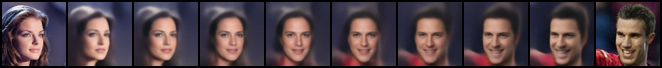

In [17]:
im = tv.utils.make_grid(interpolations, nrow=steps+2)
tvf.to_pil_image(im)